# Setup

## Colab setup

Run the following cells in order (by pressing `Shift-Enter` or clicking on the "play" button at the top-left of a cell when mousing over it). When a warning pops up, choose "Run anyway".

In [ ]:
!rm -r sample_data
!git clone https://github.com/SimoneBarbaro/data_science_lab_project.git

In [ ]:
import os
os.chdir("./data_science_lab_project/data")
!wget -O TWOSIDES_medDRA.csv.gz https://polybox.ethz.ch/index.php/s/Uemf21AIiZ7ooNi/download
os.chdir("..")

While waiting for the download above to complete, open the file browser on the left by clicking on the folder icon.

**Upload the results archive `results_2020_11_27.zip` ([Polybox link](https://polybox.ethz.ch/index.php/f/2160436597)) to the `data_science_lab_project` folder** by hovering over the folder and choosing "Upload" from the three-dots menu that appears on the right. `results_2020_11_27.zip` should then be within the `data_science_lab_project` folder next to the `src` and `data` folders, which you can check by expanding the folder contents by clicking on the triangle on the left of the folder name.

Additionally, **upload the paired SPiDER data `matrix_spider_full.pkl.gz` ([Polybox link](https://polybox.ethz.ch/index.php/f/2160073828)) and `matrix_spider_names_full.pkl.gz` ([Polybox link](https://polybox.ethz.ch/index.php/f/2160073720)) into the `data` folder** (within `data_science_lab_project`) using the three-dots menu of the `data` folder. Expand the `data` folder and check that `matrix_spider_full.pkl.gz` and `matrix_spider_names_full.pkl.gz` as well as `TWOSIDES_medDRA.csv.gz` downloaded automatically above are present in it.

In [ ]:
!unzip results_*.zip

In [ ]:
!pip install -r src/requirements.txt
os.chdir("src")

Running the following cell should now list the runs that can be analyzed: each is a clustering method followed by the number of clusters and other relevant parameters.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
cwd = os.getcwd()
results_directory = "../results"
results_directory = os.path.join(cwd, results_directory)
for f in sorted(os.listdir(results_directory)):
    path = os.path.join(results_directory, f)
    if os.path.isdir(path):
        print(f)

aggl10ave
aggl15
aggl20
aggl30
aggl5ave
aggl8
gmm10
gmm15
gmm20
gmm30
kmeans10
kmeans16
kmeans18
kmeans20
kmeans25norm
kmeans30
results
spider_kmeans_10_test
test
tiger_kmeans_10_test


## Choose one of the clustering metod from above here

In [17]:
name_analysis = 'aggl15'

Some of the results are done on spiders, others on tiger. The name of the analysis should say which one it is. Older runs did not have this because tiger was still not available so if no dataset is specified in the run name assume it's spider. 

In [18]:
dataset = "spider"

In [19]:
# The following sets up filepath variables for use later in the notebook
result_path = os.path.join(results_directory, name_analysis)
analysis_path = os.path.join(result_path, "analysis")

# Clusters

Show the beginning of the clustering results file to check it was read correctly:

In [20]:
pth = os.path.join(result_path, 'results.csv')
clustering_results = pd.read_csv(pth)
display(clustering_results.head())
print("Number of drug pairs: {}\nNumber of clusters: {} (from {} to {})".format(clustering_results.shape[0], clustering_results["cluster"].drop_duplicates().count(), clustering_results["cluster"].min(), clustering_results["cluster"].max()))

,name1,name2,cluster
0,6-aminocaproic acid,acetaminophen,7.0
1,6-aminocaproic acid,acyclovir,7.0
2,6-aminocaproic acid,albuterol,7.0
3,6-aminocaproic acid,aspirin,7.0
4,6-aminocaproic acid,bumetanide,7.0


Number of drug pairs: 81157
Number of clusters: 15 (from 0.0 to 14.0)


Query for a specific drug pair provide names of both drugs in cell below:

In [21]:
name1 = 'tamoxifen'
name2 = 'bupropion'
clustering_results[(clustering_results['name1'] == name1) & (clustering_results['name2'] == name2)]

,name1,name2,cluster
42662,tamoxifen,bupropion,5.0


# Side effects analysis

## Choose a level of side effects

There are five levels to the MedDRA hierarchy, of which four are available here. `System Organ Classes (SOC)` are the highest level terms based on location, etiology, or purpose. `High Level Group Terms (hlgt)` which are the next highest level terms are groups of `High Level Terms (hlt)` grouped together by anatomy, pathology, physiology, etiology and function. Likewise, `High Level Terms (hlt)`s themselves are groups of `Preferred Terms (pt)`, the most specific terms, grouped together by the same criteria.

In the cell below, choose the analysis level of Meddra terms to look at for the analysis.

In [22]:
analysis_level = 'soc'

In [23]:
pth = os.path.join(analysis_path, 'scores_' + analysis_level + '_term.csv')
sideeffect_results = pd.read_csv(pth)
sideeffect_results

,cluster,soc_term,perc,tfidf_score,rank
0,0.0,Nervous system disorders,0.096907,0.404740,1.0
1,0.0,Gastrointestinal disorders,0.076138,0.317997,2.0
2,0.0,General disorders and administration site cond...,0.073008,0.304925,3.0
3,0.0,Vascular disorders,0.072191,0.301512,4.0
4,0.0,Investigations,0.063097,0.263530,5.0
...,...,...,...,...,...
385,14.0,Surgical and medical procedures,0.010883,0.045339,22.0
386,14.0,Social circumstances,0.005781,0.024086,23.0
387,14.0,Ear and labyrinth disorders,0.005615,0.023395,24.0
388,14.0,"Pregnancy, puerperium and perinatal conditions",0.003379,0.014080,25.0


Show the top `N` side effects per group:

In [24]:
N = 4

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(sideeffect_results.groupby("cluster").head(N).set_index(["cluster", "{}_term".format(analysis_level)]))

perc  \
cluster soc_term                                                       
0.0     Nervous system disorders                            0.096907   
        Gastrointestinal disorders                          0.076138   
        General disorders and administration site condi...  0.073008   
        Vascular disorders                                  0.072191   
1.0     Nervous system disorders                            0.098415   
        Gastrointestinal disorders                          0.076006   
        General disorders and administration site condi...  0.075297   
        Vascular disorders                                  0.071366   
2.0     Nervous system disorders                            0.098477   
        Gastrointestinal disorders                          0.076074   
        General disorders and administration site condi...  0.075366   
        Vascular disorders                                  0.072117   
3.0     Nervous system disorders                            0.097021   
        Gastrointestinal disorders                          0.075101   
        General disorders and administration site condi...  0.073832   
        Vascular disorders                                  0.073596   
4.0     Nervous system disorders                            0.098606   
        General disorders and administration site condi...  0.076015   
        Gastrointestinal disorders                          0.075137   
        Vascular disorders                                  0.073037   
5.0     Nervous system disorders                            0.097641   
        Gastrointestinal disorders                          0.076790   
        General disorders and administration site condi...  0.073607   
        Vascular disorders                                  0.071513   
6.0     Nervous system disorders                            0.095562   
        Gastrointestinal disorders                          0.075873   
        General disorders and administration site condi...  0.071953   
        Vascular disorders                                  0.071777   
7.0     Nervous system disorders                            0.101769   
        General disorders and administration site condi...  0.077190   
        Gastrointestinal disorders                          0.074982   
        Vascular disorders                                  0.072801   
8.0     Nervous system disorders                            0.098413   
        Gastrointestinal disorders                          0.076909   
        General disorders and administration site condi...  0.074664   
        Vascular disorders                                  0.070589   
9.0     Nervous system disorders                            0.100424   
        General disorders and administration site condi...  0.077294   
        Gastrointestinal disorders                          0.075899   
        Vascular disorders                                  0.071156   
10.0    Nervous system disorders                            0.096975   
        Gastrointestinal disorders                          0.076375   
        General disorders and administration site condi...  0.073684   
        Vascular disorders                                  0.072663   
11.0    Nervous system disorders                            0.099370   
        General disorders and administration site condi...  0.075918   
        Gastrointestinal disorders                          0.074240   
        Vascular disorders                                  0.073702   
12.0    Nervous system disorders                            0.099789   
        General disorders and administration site condi...  0.076469   
        Gastrointestinal disorders                          0.076117   
        Vascular disorders                                  0.071626   
13.0    Nervous system disorders                            0.098334   
        Gastrointestinal disorders                          0.076435   
        General disorders and ad

## Clusters numbers

Show cluster labels and count them:

In [25]:
sideeffect_results["cluster"].drop_duplicates().values

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14.])

In [26]:
num_clusters = sideeffect_results["cluster"].drop_duplicates().count()
num_clusters

15

## Choose a specific cluster to inspect

Below, one can choose which specific cluster to look at and analyze the significant side effects by changing the `cluster_no` variable.

In [27]:
cluster_no = 0

In [28]:
sideeffect_results[sideeffect_results['cluster'] == cluster_no]

,cluster,soc_term,perc,tfidf_score,rank
0,0.0,Nervous system disorders,0.096907,0.404740,1.0
1,0.0,Gastrointestinal disorders,0.076138,0.317997,2.0
2,0.0,General disorders and administration site cond...,0.073008,0.304925,3.0
3,0.0,Vascular disorders,0.072191,0.301512,4.0
4,0.0,Investigations,0.063097,0.263530,5.0
5,0.0,"Respiratory, thoracic and mediastinal disorders",0.062740,0.262041,6.0
6,0.0,Psychiatric disorders,0.061698,0.257687,7.0
7,0.0,Musculoskeletal and connective tissue disorders,0.061193,0.255578,8.0
8,0.0,"Injury, poisoning and procedural complications",0.059374,0.247980,9.0
9,0.0,Cardiac disorders,0.053415,0.223091,10.0


# Significance Analysis

The significance analysis shows which side effects are shown to be significant in each cluster using the [Grubbs test](https://en.wikipedia.org/wiki/Grubbs%27s_test#One-sided_case) at a significance level of 0.005. Below, choose a level of MedDRA hierarchy to observe the significant side effects predicted in each cluster. <!-- The `alpha` value determines the statistical significance level for which effects are significant. Currently only results for `alpha = 0.005` are computed. // alpha = 0.005  # Currently only 0.005 is available, do not change -->

## Choose a level of side effects

In [29]:
analysis_level = 'soc'

In [30]:
pth = os.path.join(analysis_path, 'significant_' + analysis_level + '_ranks_' + str(0.005) + '.csv')
statistical_results = pd.read_csv(pth)
statistical_results

,cluster,soc_term,perc,tfidf_score,rank,grubbs
0,14.0,Immune system disorders,0.020815,0.086718,16.0,3.741657
1,14.0,Hepatobiliary disorders,0.017347,0.072272,18.0,3.741657


Look at the significant results summary. Each row shows a drug pair, its cluster and the top `soc`, top 3 `hlgt`, top 3 `hlt` and top 3 `pt` side effects for that cluster. `NaN` means the cluster did not have a significant side effect at a given level.

In [31]:
pth = os.path.join(analysis_path, 'significant_summary.csv')
summary_results = pd.read_csv(pth)
summary_results

FileNotFoundError: [Errno 2] File b'D:\\Simone\\ETH\\materie\\data science lab\\data_science_lab_project\\src\\../results\\aggl15\\analysis\\significant_summary.csv' does not exist: b'D:\\Simone\\ETH\\materie\\data science lab\\data_science_lab_project\\src\\../results\\aggl15\\analysis\\significant_summary.csv'

Query for specific drugs

In [32]:
name1 = 'tamoxifen'
name2 = 'bupropion'
summary_results[(summary_results['name1'] == name1) & (summary_results['name2'] == name2)]

NameError: name 'summary_results' is not defined

# Target distribution for significant clusters

This block will run the Interactive Analysis for identifying the strongest targets in each cluster.

In [33]:
from experiment.interactive_analysis import InteractiveAnalyzer

This may take some time as it needs to load TWOSIDES for further analysis.

In [34]:
analyzer = InteractiveAnalyzer(dataset, result_path)

#### Choose the level, the number of clusters to consider and the number of targets per cluster to show

In [35]:
analysis_level = 'hlgt'
targets_per_cluster = 5
cluster_number = clustering_results["cluster"].drop_duplicates().count()

In [36]:
significant_clusters, important_targets = analyzer.get_important_data(analysis_level, cluster_number, targets_per_cluster)
significant_clusters

,cluster,hlgt_term,perc,tfidf_score,rank,grubbs,counts
0,12.0,Respiratory disorders NEC,0.027968,0.244866,4.0,3.741657,5
1,14.0,Gastrointestinal motility and defaecation cond...,0.007456,0.066014,40.0,3.273950,11
2,14.0,Gastrointestinal inflammatory conditions,0.005152,0.045617,55.0,3.190625,11
3,14.0,Skin and subcutaneous tissue infections and in...,0.004137,0.036631,70.0,2.889260,11
4,12.0,Lipid metabolism disorders,0.002974,0.026039,94.0,2.849173,5
5,14.0,Connective tissue disorders (excl congenital),0.001472,0.013029,140.0,2.814657,11
6,14.0,Haematopoietic neoplasms (excl leukaemias and ...,0.000880,0.007788,177.0,2.940853,11
7,13.0,Anal and rectal conditions NEC,0.000748,0.006671,195.0,2.808994,2
8,14.0,Anal and rectal conditions NEC,0.000714,0.006320,199.0,1.748997,11
9,14.0,Mycobacterial infectious disorders,0.000673,0.005960,204.0,3.143647,11


#### Choose a specific cluster to inspect from the column "cluster" above
as well as a threshold value (between 0 and 2) representing sufficient probability for a drug pair to interact with a target.

In [43]:
cluster_no = 3
threshold = 0.5

Descriptive statistics of the distribution of SPiDER predictions for important target of the chosen cluster:

In [46]:
important_targets = analyzer.get_important_targets(cluster_no, targets_per_cluster)
desc = important_targets.describe()
frac = (important_targets > threshold).sum()/(important_targets.count())
frac = frac.rename("Fraction above Threshold")
desc.append(frac)

,Serine Threonine Kinase,Potassium Channel,"Endopeptidase (Serine Endopeptidase, Serine Protease)",Sodium Channel,Integrins
count,6909.000000,6909.000000,6909.000000,6909.000000,6909.000000
mean,1.104971,1.080359,1.024457,1.015012,0.960586
std,0.508340,0.520173,0.459080,0.498184,0.476641
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.812000,0.759000,0.731000,0.606000,0.499000
50%,1.004000,0.997000,0.973000,0.979000,0.949000
75%,1.438000,1.444000,1.371000,1.417000,1.368000
max,1.986000,1.993000,1.976000,1.997000,1.993000
Fraction above Threshold,0.813576,0.799103,0.800261,0.756260,0.739470


#### Choose a target to visualize from the columns above

In [41]:
target = 'Serine Threonine Kinase'

Histogram:

Text(0.445, 149.1, 'threshold')

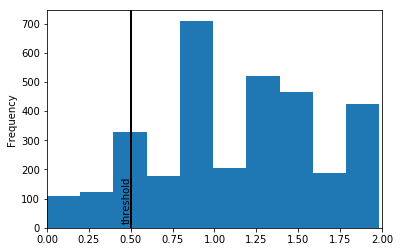

In [42]:
important_targets[cluster_no][target].plot.hist(xlim=[0,2])
plt.axvline(threshold, color='k', linewidth=2)
plt.text(threshold-0.055, plt.axis()[3]*0.2, 'threshold', rotation=90)